# Music Popularity Prediction



#### Dataset Link: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import random
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
import warnings

In [ ]:

#Sklearn Libraries
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn import linear_model, tree
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
#Tensorflow and Keras libraries
import tensorflow as tf
import keras
from keras import layers

In [ ]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
url = '/content/drive/My Drive/CS235 - Data Mining Project/Data/dataset.csv'
df = pd.read_csv(url)

### Drop Duplicates and Rows Containing Null Values

In [ ]:
df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1, inplace = True)
df.dropna(inplace=True) #deleting null instances

df = df[~df.duplicated()==1] #deleting duplicate instances

### Data Overview

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,106907.0,35.358124,21.336746,0.000,20.0000,37.000000,51.00000,100.000
duration_ms,106907.0,229992.889437,108550.183918,0.000,175493.0000,214761.000000,264293.00000,5237295.000
danceability,106907.0,0.565062,0.173726,0.000,0.4540,0.578000,0.69300,0.985
energy,106907.0,0.642874,0.252413,0.000,0.4710,0.686000,0.85600,1.000
key,106907.0,5.303544,3.555742,0.000,2.0000,5.000000,8.00000,11.000
loudness,106907.0,-8.302353,5.060974,-49.531,-10.0810,-7.056000,-5.01900,4.532
mode,106907.0,0.634103,0.481683,0.000,0.0000,1.000000,1.00000,1.000
speechiness,106907.0,0.085476,0.107626,0.000,0.0359,0.049000,0.08500,0.965
acousticness,106907.0,0.313754,0.332755,0.000,0.0154,0.168000,0.59600,0.996
instrumentalness,106907.0,0.163289,0.314984,0.000,0.0000,0.000058,0.06835,1.000


### Examine the distribution of our target variable Popularity

[Text(0.5, 1.0, 'Popularity Distribution'),
 Text(0.5, 0, 'Popularity'),
 Text(0, 0.5, 'Song Count')]

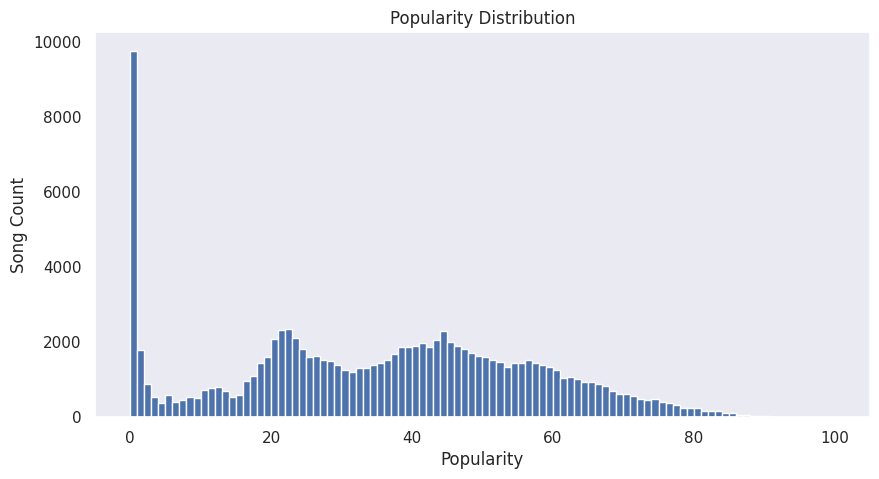

In [ ]:

fig, ax = plt.subplots(figsize=(10,5)) #setting the figure size
plt.hist(df['popularity'], bins=100) #computing the histogram of popularities
ax.grid(False)
ax.set(title='Popularity Distribution', xlabel='Popularity', ylabel='Song Count')

#### Correlation Heatmap

<Axes: >

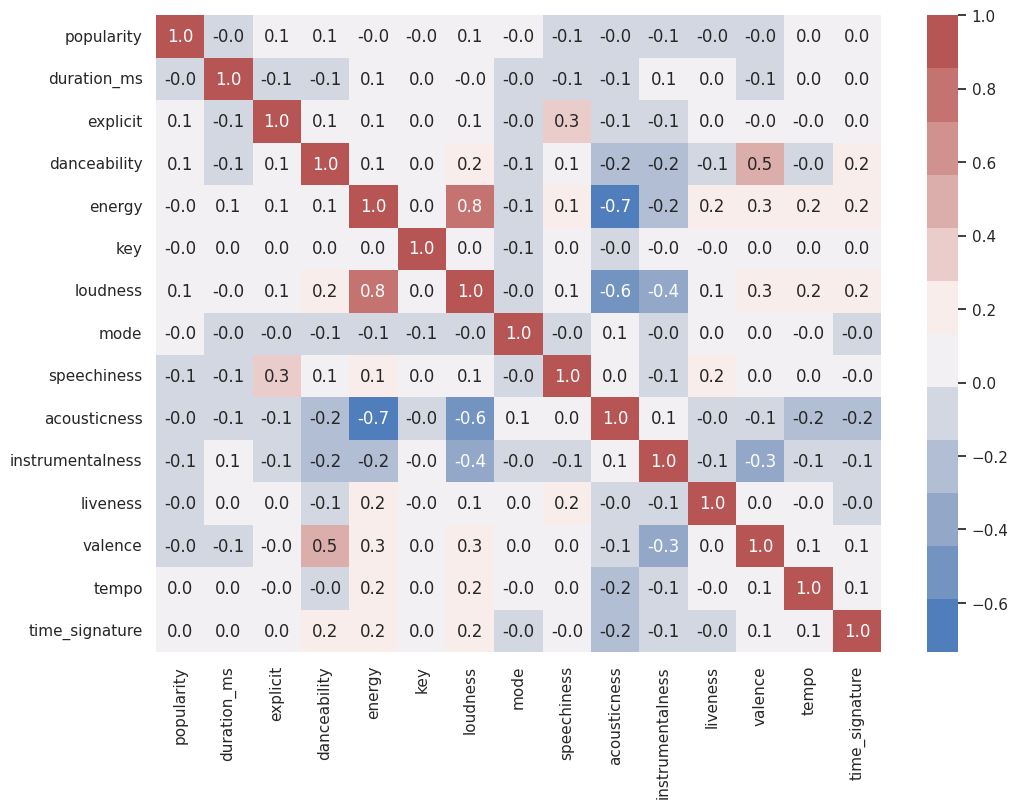

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap = sns.color_palette("vlag", 12))

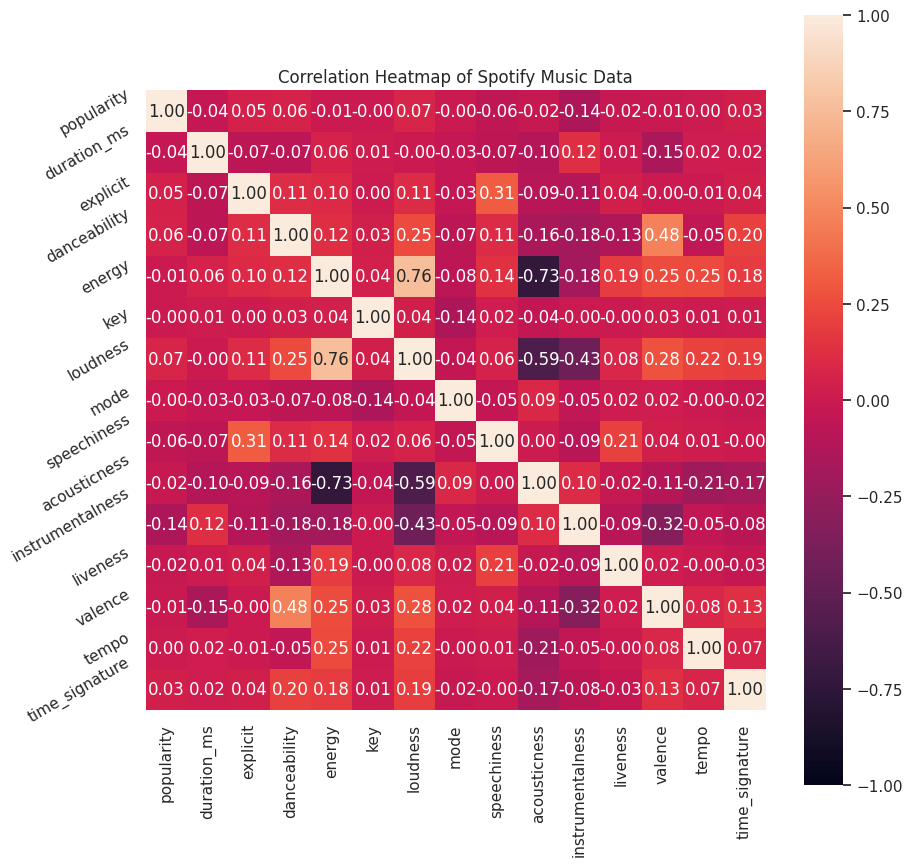

In [ ]:
def correlation_map():

  correlation = df.corr(method='pearson', numeric_only=True)
  plt.figure(figsize=(10,10))

  plt.title('Correlation Heatmap of Spotify Music Data')

  ax = sns.heatmap(correlation, vmin=-1.0, vmax=1.0, square=True, annot=True, fmt='.2f', linecolor='white')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  ax.set_yticklabels(ax.get_yticklabels(), rotation=30)

  plt.show()

correlation_map()

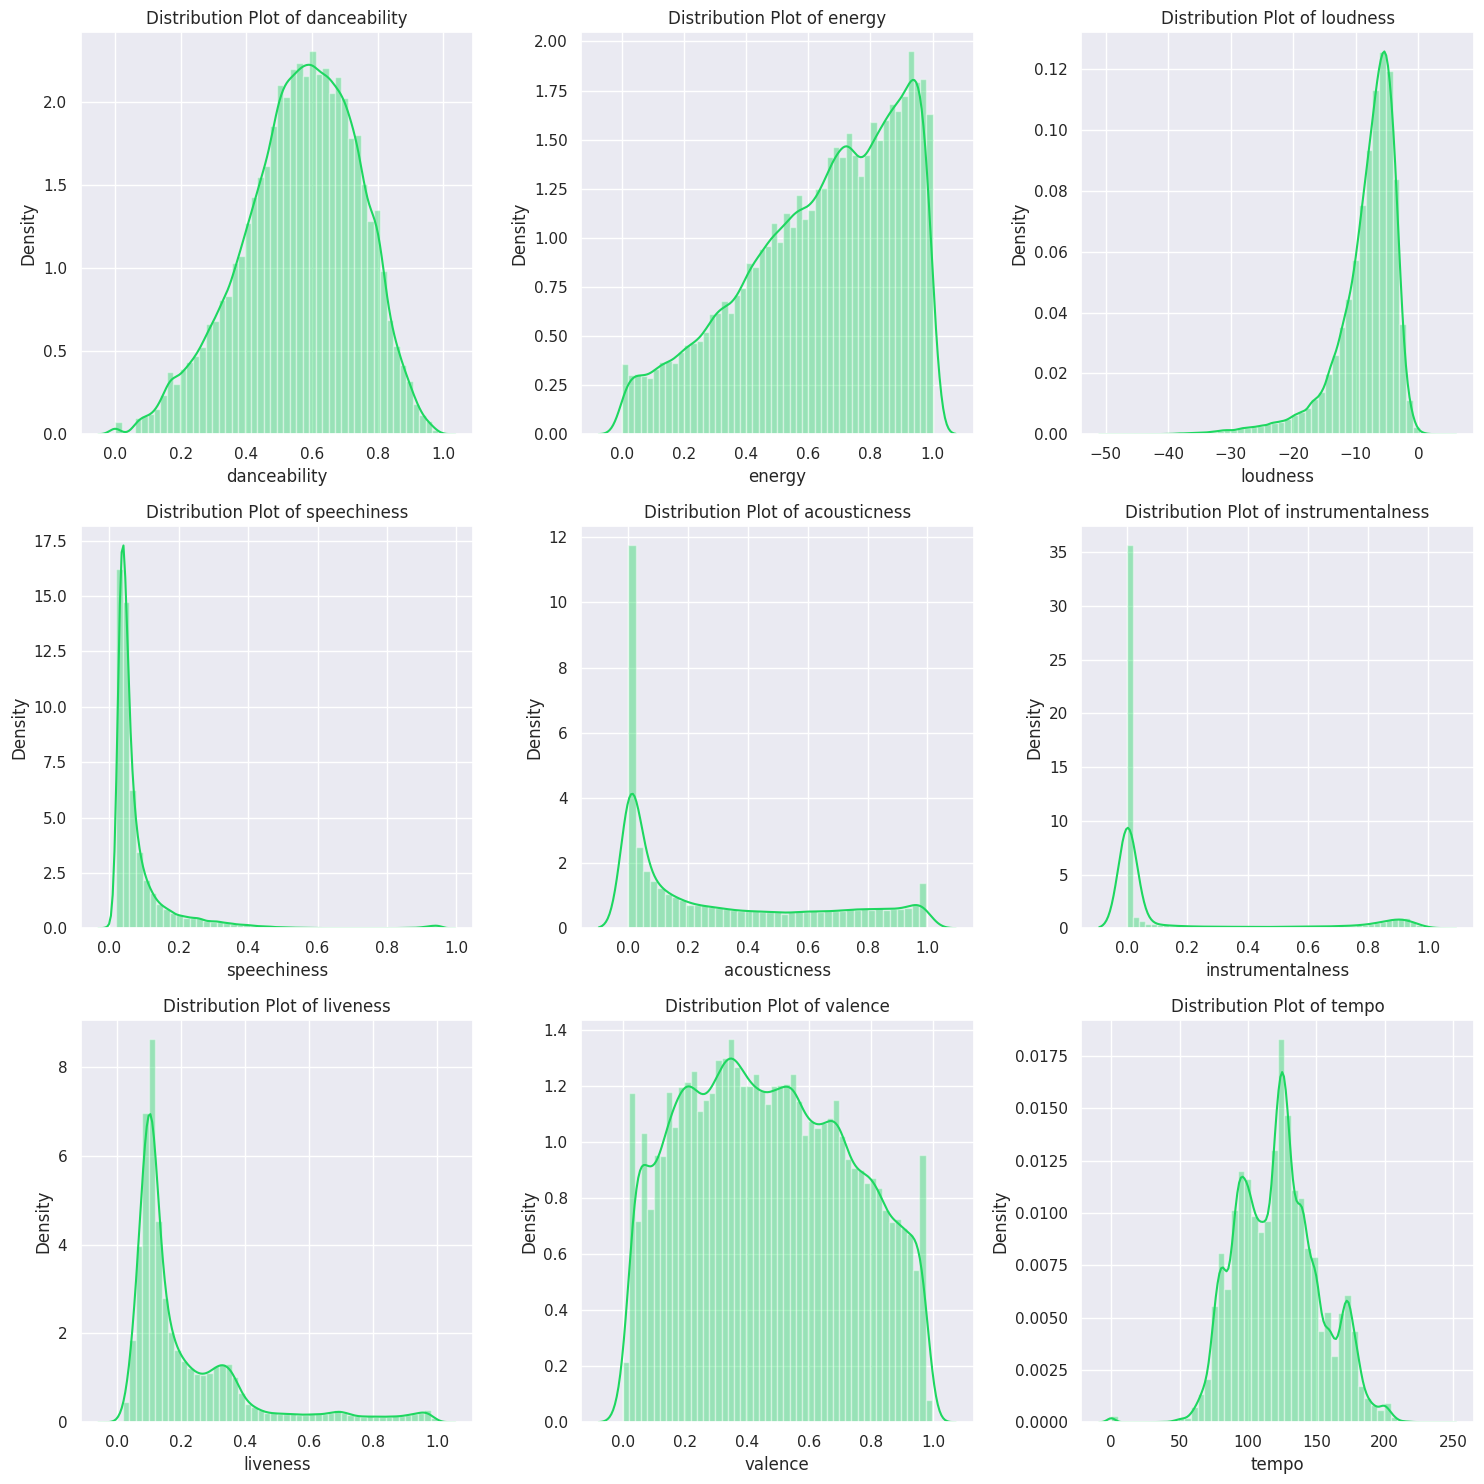

In [ ]:
# Distribution of numeric features
num_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
# num_cols = df.columns.tolist()
df_t = df.copy()
n_cols = len(num_cols)
n_rows = int(np.ceil(n_cols / 3))

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))

for i, col in enumerate(num_cols):
    row_idx = i // 3
    col_idx = i % 3
    sns.distplot(df_t[col], ax=axes[row_idx, col_idx], kde=True, color='#1ED760')

    axes[row_idx, col_idx].set_title(f"Distribution Plot of {col}")
    axes[row_idx, col_idx].set_xlabel(col)

for i in range(n_cols, n_rows*3):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()

plt.show()

#### Convert 'track_genre' feature into a categorical value

In [ ]:
#print(set(df['track_genre']))
label_encoder = LabelEncoder()
df['track_genre'] = label_encoder.fit_transform(df['track_genre'])
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


In [ ]:
#Get all the valid columns of the dataset
columns = list(df.columns)
print(columns)

['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [ ]:
#helper method to get train and test dataset
#pass in the columns you want to be included in your dataset
def get_data(df=df, columns=columns, ignore_columns=None, test_size = None, train_size = None):

  if test_size is None and train_size is None:
    print("Using default split of 80-20")
    test_size = 0.2

  if test_size:
    train_size = 1 - test_size

  elif train_size:
    test_size = 1 - train_size

  print("Using Train {} - {} Test split".format(train_size, test_size))

  if np.float64(test_size) + np.float64(train_size) > 1:
    raise Exception("Sorry, check your train-test split")

  df_ = df[columns].copy()

  X = df_.loc[:,df.columns != 'popularity'].values
  Y = df['popularity'].values

  X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = train_size, test_size = test_size)

  X_train = np.asarray(X_train, dtype=np.float32) #converting list to numpy
  X_test = np.asarray(X_test, dtype=np.float32)   #converting list to numpy
  y_train = np.asarray(y_train, dtype=np.float32) #converting list to numpy
  y_test = np.asarray(y_test, dtype=np.float32)   #converting list to numpy

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = get_data(df, columns)

Using default split of 80-20
Using Train 0.8 - 0.2 Test split


In [ ]:
def model_metrics(model, X_test, y_test, decimals = 5, X_train = X_train, y_train = y_train, fit=True, y_pred=None):

    start  = datetime.now()

    if not fit and y_pred is None:
      raise Exception('Pass predicted values (y_pred)')

    if fit:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

    mse = np.round(metrics.mean_squared_error(y_test, y_pred),decimals)
    mae = np.round(metrics.mean_absolute_error(y_test, y_pred),decimals)
    mape = np.round(metrics.mean_absolute_percentage_error(y_test, y_pred),decimals)
    r2 = np.round(metrics.r2_score(y_test, y_pred),decimals)

    metric_output = {
        'MSE': mse
        , 'MAE': mae
        , 'MAPE': mape
        , 'R2_score': r2
        , 'Time': (datetime.now() - start).seconds
    }
    return metric_output

# Linear Regression



In [ ]:
lm = LinearRegression() # Linear Regression
model_metrics(lm, X_test, y_test)

{'MSE': 431.35367,
 'MAE': 17.02432,
 'MAPE': 1.4632123e+16,
 'R2_score': 0.04136,
 'Time': 0}

#### Statistical

In [ ]:
from scipy import stats

# Linear Regression t-statistic, p-value
lm.fit(X_train, y_train)
y_preds = lm.predict(X_test)
t_value, p_value=stats.ttest_ind(y_test, y_preds, equal_var=False)
print(t_value)
print(p_value)

0.6827412020226139
0.49477720997591124


# XGBoost

### Cross-Validation for tunning hyper-parameters

In [ ]:
# XGBoost Regressor
#Importing Packages
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# from sklearn.preprocessing import Imputer

param_tuning = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [5],
    'subsample': [0.8],
    'gamma': [0, 0.5],
    'n_estimators': [100, 200, 500], #因為scratch會跑很慢，不建議設太大
}

xgb_model = XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                        param_grid = param_tuning,
                        scoring = ['neg_mean_squared_error','neg_mean_absolute_error','r2'],  #MSE
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1,
                        refit='neg_mean_squared_error')

gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.5], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5], 'n_estimators': [100, 200, 500],
                         'subsample': [0.8]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=1)

In [ ]:
print(len(gsearch.cv_results_['params']))
gsearch.cv_results_

12


{'mean_fit_time': array([1.25492177, 2.4764986 , 6.09416161, 1.88515639, 2.38958707,
        5.66234999, 1.1866303 , 2.53398962, 5.85470381, 1.69170923,
        2.14260087, 5.39465275]),
 'std_fit_time': array([0.07555198, 0.33624495, 1.09902491, 0.90065932, 0.51884237,
        1.17207233, 0.01293367, 0.61355813, 0.70584484, 0.25062107,
        0.20411762, 1.51877489]),
 'mean_score_time': array([0.04776745, 0.09891667, 0.26624641, 0.08976707, 0.08938074,
        0.23937654, 0.05215468, 0.11088629, 0.25598555, 0.08914566,
        0.08815989, 0.24798622]),
 'std_score_time': array([0.00168862, 0.01675289, 0.08182234, 0.07609667, 0.00146173,
        0.02683751, 0.01261945, 0.03331192, 0.06599852, 0.02106687,
        0.00087861, 0.08533835]),
 'param_gamma': masked_array(data=[0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtyp

In [ ]:
# print all test socres for each parameter combination
print(gsearch.cv_results_['params'])
print(gsearch.cv_results_['mean_test_neg_mean_squared_error'])
print(gsearch.cv_results_['mean_test_neg_mean_absolute_error'])
print(gsearch.cv_results_['mean_test_r2'])
# [['params', 'mean_test_score']]

[{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}, {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}, {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}, {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}, {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}, {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}, {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, '

In [ ]:
# Print out the optimal parameter for XGBoost
gsearch.best_params_

{'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 500,
 'subsample': 0.8}

In [ ]:
# The grid.best_score_ is the average of all cv folds for a single combination of the parameters you specify in the tuned_params.
-1*gsearch.best_score_

289.28887329101565

In [ ]:
XGBreg = XGBRegressor(learning_rate=0.1,
                      subsample = 0.8,
                      n_estimators=500,
                      max_depth=5,
                      gamma=0.5
)

In [ ]:
# XGBoost Result
model_metrics(XGBreg, X_test, y_test)

{'MSE': 283.88055, 'MAE': 12.38821, 'MAPE': 1.1268341e+16, 'Time': 3}

#### Statistical

In [ ]:
# XGBoost Regression t-statistic, p-value
XGBreg.fit(X_train, y_train)
y_preds = XGBreg.predict(X_test)
t_value, p_value=stats.ttest_ind(y_test, y_preds, equal_var=False)
print(t_value)
print(p_value)

0.6792584368517864
0.49697882142089245


### Feature Importance

In [ ]:
xgb_model = XGBreg.fit(X_train, y_train)
xgb_ftr_imp = xgb_model.feature_importances_

In [ ]:
feature_importances_df = pd.DataFrame(xgb_ftr_imp, index = df.loc[:,df.columns != 'popularity'].columns) \
.reset_index() \
.rename(columns = {0: 'importance', 'index': 'feature'}) \
.sort_values('importance', ascending = False)

Text(0.5, 1.0, 'Importance of features for predicting Popularity using XGBoost')

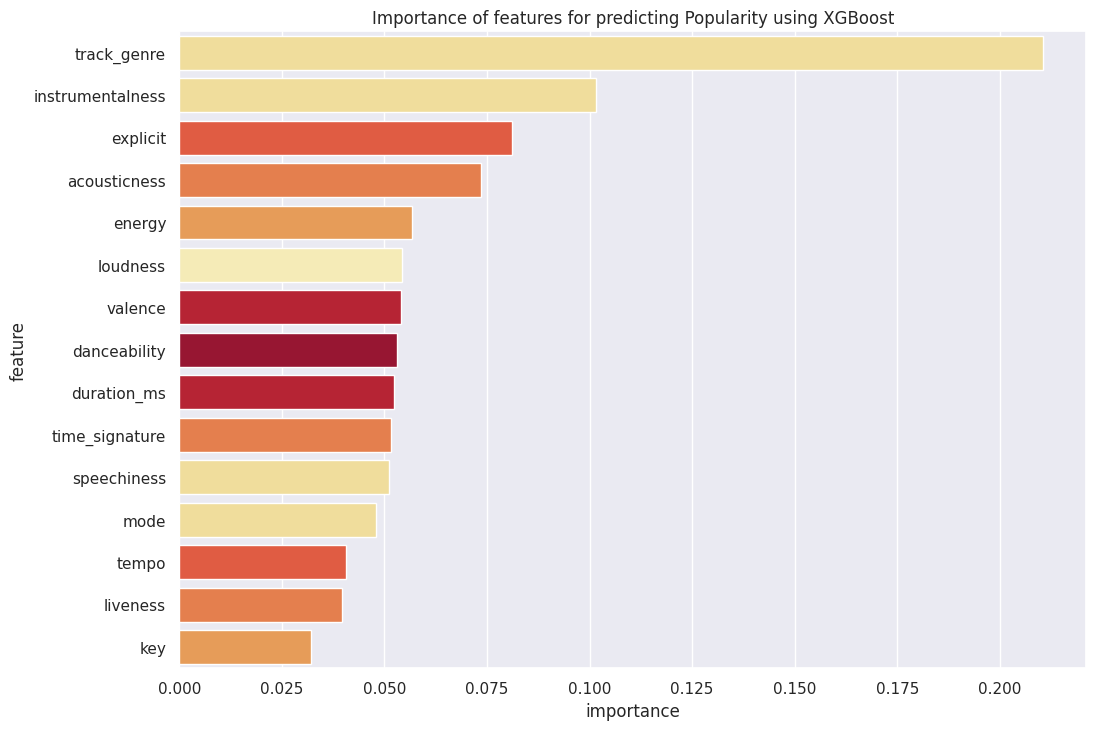

In [ ]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
sns.barplot(y=feature_importances_df['feature'], x = feature_importances_df['importance'], palette=colors_from_values(np.random.random(10), "YlOrRd")).set_title('Importance of features for predicting Popularity using XGBoost')

In [ ]:
# Check the mean popularity among each track genre
dataset = pd.read_csv(url)
dataset.groupby('track_genre')['popularity'].mean().reset_index().sort_values(by='popularity', ascending=False)

,track_genre,popularity
81,pop-film,59.283
65,k-pop,56.896
15,chill,53.651
94,sad,52.379
44,grunge,49.594
...,...,...
13,chicago-house,12.339
24,detroit-techno,11.174
67,latin,8.297
93,romance,3.245


## Polynomial Regression

In [ ]:
def resample(X, Y):

  smote = SMOTE(sampling_strategy='minority')
  X_, Y_ = smote.fit_resample(X, Y)

  return X_, Y_

In [ ]:
def polynomial_regression(degree=2):

  X_train, X_test, Y_train, Y_test = get_data(df)

  poly = PolynomialFeatures(degree = 2, include_bias = False)

  X_train = poly.fit_transform(X_train)
  X_test = poly.fit_transform(X_test)

  #Standardize X
  X_train = StandardScaler().fit_transform(X_train)
  X_test = StandardScaler().fit_transform(X_test)

  polynomial_model = LinearRegression()
  polynomial_model.fit(X_train, Y_train)

  Y_pred = polynomial_model.predict(X_test)

  metrix = model_metrics(polynomial_model, X_test, Y_test, X_train = X_train, y_train = Y_train, fit=False, y_pred=Y_pred)

  return polynomial_model, metrix

In [ ]:
_, metrix = polynomial_regression(degree=2)
print(metrix)

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
{'MSE': 410.54407, 'MAE': 16.29025, 'MAPE': 1.3993072e+16, 'R2_score': 0.08741, 'Time': 0}


# Polynomial Logistic Regression

In [ ]:
#Converting the problem into a binary classification

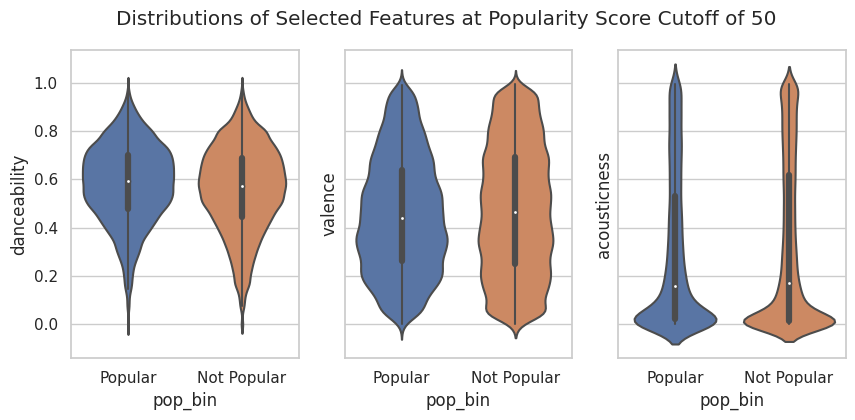

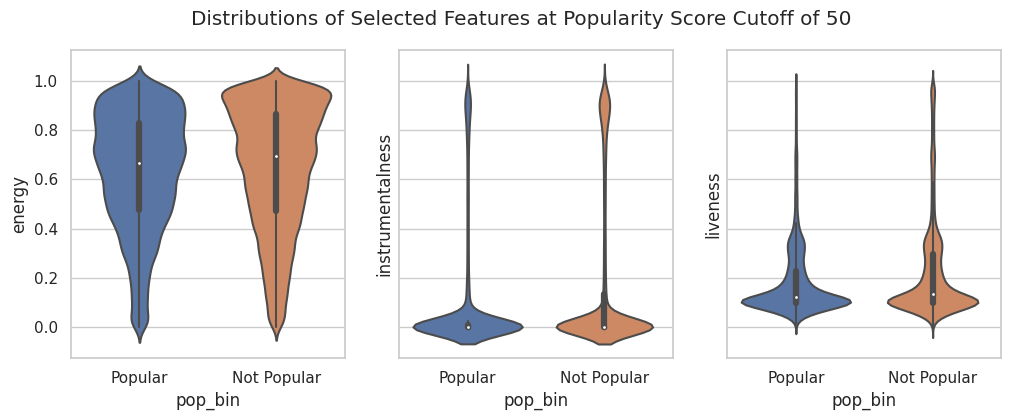

In [ ]:
def plot_violin(df, cutoff): #Took help from a Github repo to plot violin plots
    df = df.copy()

    sns.set(style="whitegrid")
    df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not Popular")

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10,4))
    fig.suptitle('Distributions of Selected Features at Popularity Score Cutoff of {}'.format(cutoff))

    sns.violinplot(x=df['pop_bin'], y=df['danceability'], ax=ax[0])
    sns.violinplot(x=df['pop_bin'], y=df['valence'], ax=ax[1])
    sns.violinplot(x=df['pop_bin'], y=df['acousticness'], ax=ax[2])

    plt.show()

    sns.set(style="whitegrid")

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    fig.suptitle('Distributions of Selected Features at Popularity Score Cutoff of {}'.format(cutoff))

    sns.violinplot(x=df['pop_bin'], y=df['energy'], ax=ax[0])
    sns.violinplot(x=df['pop_bin'], y=df['instrumentalness'], ax=ax[1])
    sns.violinplot(x=df['pop_bin'], y=df['liveness'], ax=ax[2])

    plt.show()

plot_violin(df, 50)

In [ ]:
def get_popularity_binary(df, cutoff):

  df_bin = df.copy()

  Y_bin = df['popularity'].to_numpy()
  Y_bin = [0 if i < cutoff else 1 for i in Y_bin ]
  df_bin['popularity'] = Y_bin

  return Y_bin, df_bin

In [ ]:
def get_data_bin_classfication(df, cutoff, test_size=None, train_size=None, resample_=False):
  #Convert the popularity into binary values

  _, df_bin = get_popularity_binary(df, cutoff)

  X_train, X_test, y_train, y_test = get_data(df_bin, columns, test_size, train_size)
  #print("Before resample: ", X_train.shape, y_train.shape)

  #print(Y_bin)

  if resample_:
    X_train, y_train = resample(X_train, y_train) # Only the training data is resampled. Test data distribution is maintained
    #print("After resample: ", X_train.shape, y_train.shape)

    return X_train, X_test, y_train, y_test

  return X_train, X_test, y_train, y_test

#_,_,_,_ = get_data_bin_classfication(df, 50, 0.15)

Baseline Polynomial Logistic Regression without resampling

In [ ]:
def polynomial_logistic_regression(df, degree=2, cutoff=50):

  X_train, X_test, Y_train, Y_test = get_data_bin_classfication(df, cutoff, resample_=True)

  poly_bin = PolynomialFeatures(degree = degree) # Degree by default is 2 in PolynomialFeatures - Baseline
  X_poly_train = poly_bin.fit_transform(X_train)
  X_poly_test = poly_bin.fit_transform(X_test)

  print('Standarding X')

  #Standardize X
  X_poly_train = StandardScaler().fit_transform(X_poly_train)
  X_poly_test = StandardScaler().fit_transform(X_poly_test)

  poly_logistic_regression = linear_model.LogisticRegression()

  print("Fitting model with degree {} ...".format(degree))

  model = poly_logistic_regression.fit(X_poly_train, Y_train)

  Y_pred_train = model.predict(X_poly_train)
  Y_pred_test = model.predict(X_poly_test)

  train_accuracy = metrics.accuracy_score(Y_pred_train, Y_train)
  test_accuracy = metrics.accuracy_score(Y_pred_test, Y_test)

  train_preciscion = metrics.precision_score(Y_train, Y_pred_train)
  test_preciscion = metrics.precision_score(Y_test, Y_pred_test)

  f1_train = metrics.f1_score(Y_train, Y_pred_train)
  f1_test = metrics.f1_score(Y_test, Y_pred_test)

  recall_train = metrics.recall_score(Y_train, Y_pred_train)
  recall_test = metrics.recall_score(Y_test, Y_pred_test)

  scores = {'Train Accuracy': np.round(train_accuracy, 3), 'Test Accuracy': np.round(test_accuracy, 3),
            'Train Precision': np.round(train_preciscion, 3), 'Test Precision': np.round(test_preciscion, 3),
            'F1 Train': np.round(f1_train, 3), 'F1 Test': np.round(f1_test, 3),
            'Recall Train': np.round(recall_train, 3), 'Recall Test': np.round(recall_test, 3)}

  print("Finished predicting...")

  plt.figure(figsize=(10,6))
  ConfusionMatrixDisplay.from_estimator(model, X_poly_test, Y_test)
  plt.show()

  return model, scores

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
Standarding X
Fitting model with degree 2 ...
Finished predicting...


<Figure size 1000x600 with 0 Axes>

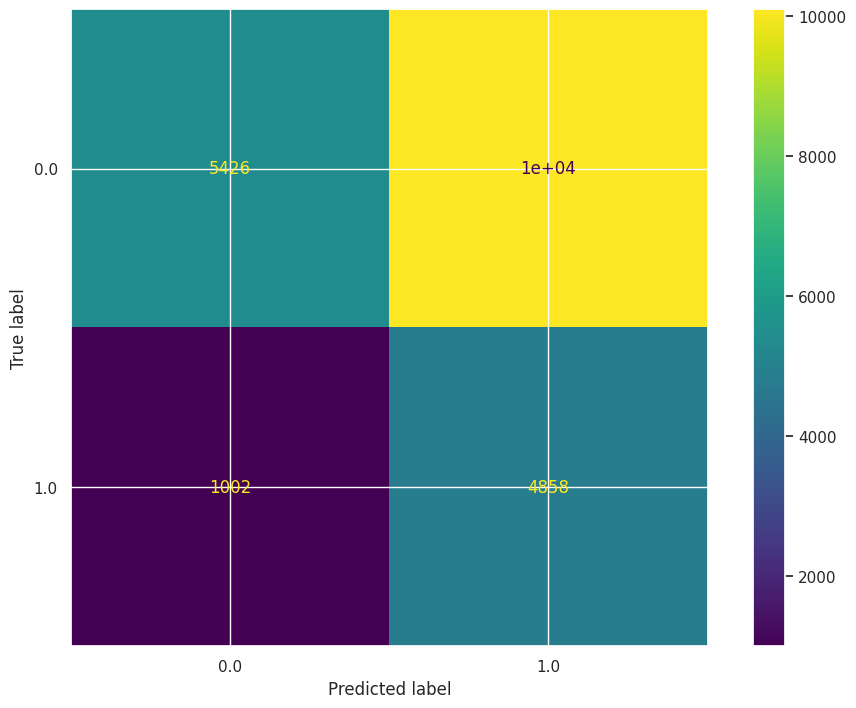

{'Train Accuracy': 0.713, 'Test Accuracy': 0.481, 'Train Precision': 0.729, 'Test Precision': 0.325, 'F1 Train': 0.702, 'F1 Test': 0.467, 'Recall Train': 0.676, 'Recall Test': 0.829}


In [ ]:
model, scores = polynomial_logistic_regression(df, 2, 50)
print(scores)

In [ ]:
#Func to try out multiple degrees and cutoffs and produce a table

In [ ]:
def n_degree_fit(n_degree=2, logistic=True):

  cutoffs = [40, 50] #Selecting the values based off on Median ~(40),
                             #75th percentile score ~(50)
  df_metrics = pd.DataFrame()

  for degree in range(1, n_degree+1):

    if not logistic:

      _, metrix = polynomial_regression(n_degree)

      metrix['Degree'] = degree
      df_metrics = df_metrics.append(metrix, ignore_index=True)

    else:

      for cutoff in cutoffs:

        _, metrix = polynomial_logistic_regression(df, degree, cutoff)

        metrix['Degree'] = degree
        metrix['Cutoff'] = cutoff

        df_metrics = df_metrics.append(metrix, ignore_index=True)

  return df_metrics

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
Standarding X
Fitting model with degree 1 ...
Finished predicting...


<Figure size 1000x600 with 0 Axes>

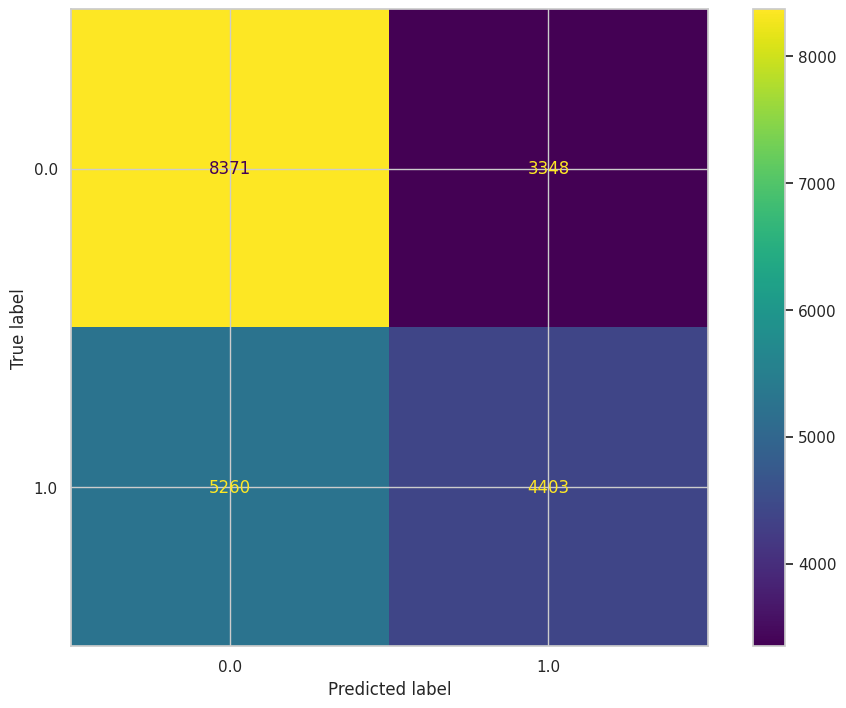

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
Standarding X
Fitting model with degree 1 ...
Finished predicting...


<Figure size 1000x600 with 0 Axes>

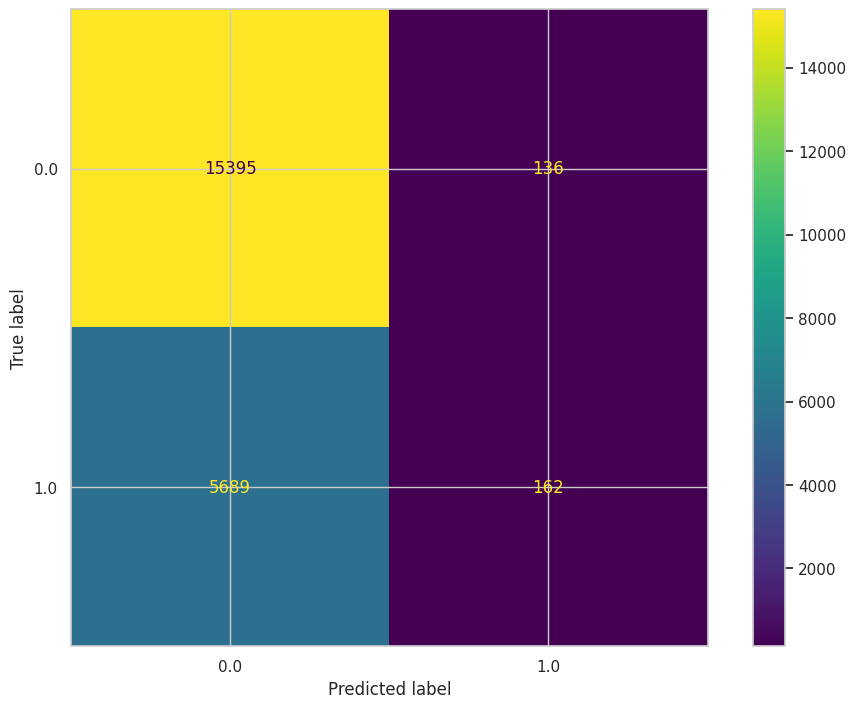

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
Standarding X
Fitting model with degree 2 ...
Finished predicting...


<Figure size 1000x600 with 0 Axes>

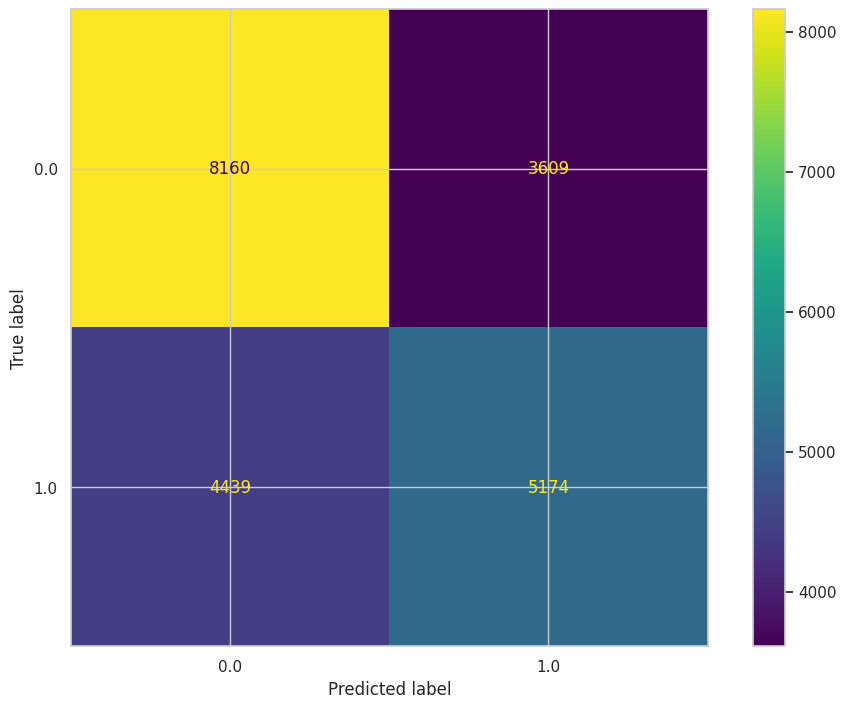

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
Standarding X
Fitting model with degree 2 ...
Finished predicting...


<Figure size 1000x600 with 0 Axes>

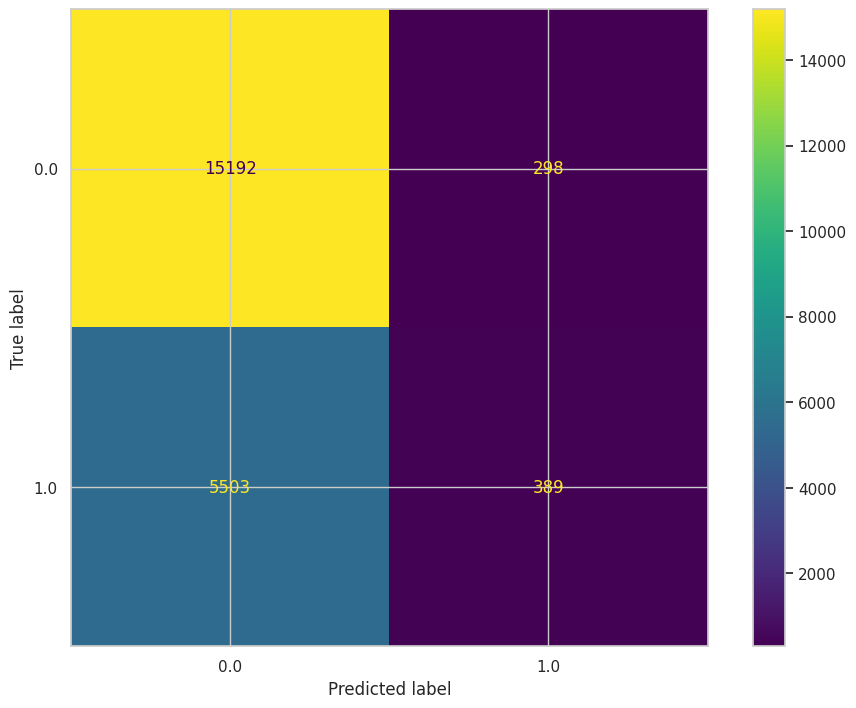

In [ ]:
df_metrix = n_degree_fit(n_degree=2,logistic=True)

In [ ]:
df_metrix

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,F1 Train,F1 Test,Recall Train,Recall Test,Degree,Cutoff
0,0.598,0.597,0.571,0.568,0.508,0.506,0.457,0.456,1.0,40.0
1,0.726,0.728,0.529,0.544,0.047,0.053,0.025,0.028,1.0,50.0
2,0.625,0.624,0.597,0.589,0.567,0.563,0.541,0.538,2.0,40.0
3,0.728,0.729,0.531,0.566,0.119,0.118,0.067,0.066,2.0,50.0


# Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
#selecting features we want to use
num_cols = ['duration_ms', "tempo", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "danceability", "energy", "key", "mode", "time_signature"]
df_scaled = df[num_cols].copy()

In [ ]:
X = df_scaled.values.tolist() #converting the data of features from CSV to list
y = df['popularity'].values.tolist() #converting the data of popularity values from CSV to list

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) #splitting the data into train and test with ratio of 8 to 2
X_train = np.asarray(X_train, dtype=np.float32) #converting list to numpy
X_test = np.asarray(X_test, dtype=np.float32)   #converting list to numpy
y_train = np.asarray(y_train, dtype=np.float32) #converting list to numpy
y_test = np.asarray(y_test, dtype=np.float32)   #converting list to numpy

X_train_std = StandardScaler().fit_transform(X_train) #standardizing features by removing the mean and scaling to unit variance
X_test_std = StandardScaler().fit_transform(X_test)   #standardizing features by removing the mean and scaling to unit variance

Regression Problem

In [ ]:
input_shape = X_train.shape[1:] #input shape

#setting a random seed to make the results reproducible
np.random.seed(42)
tf.random.set_seed(42)

nn_model = keras.Sequential(name='nn_model') #creating the sequential neural network

nn_model.add(layers.Flatten(input_shape=input_shape)) #adding input layer to flatten the input into 1D

nn_model.add(layers.BatchNormalization()) #adding batch normalization layer

#adding five hidden dense layers with relu activation function and batch normalization layers
nn_model.add(layers.Dense(256, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(128, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(64, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.BatchNormalization())

nn_model.add(layers.Dense(1, activation='sigmoid')) #adding the output layer with sigmoid activation function

opt = keras.optimizers.Adam(learning_rate=0.01)

#adding binary crossentropy as the loss function, adam as the optimizer, and accuracy, mse, mae, and mape as the evaluation metric
nn_model.compile(loss='mse',
            optimizer=opt,
            metrics=['mse', 'mae', 'mape'])

nn_model.summary() #printing model's architecture

nn_model_history = nn_model.fit(X_train_std, y_train, epochs=500, batch_size=64, verbose=1, validation_data=(X_test_std, y_test))

Model: "nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 13)                0         
                                                                 
 batch_normalization_6 (Bat  (None, 13)                52        
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               3584      
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512

Binary Classification Problem

[Text(0.5, 1.0, 'Popularity Distribution'),
 Text(0.5, 0, 'Popularity'),
 Text(0, 0.5, 'Song Count')]

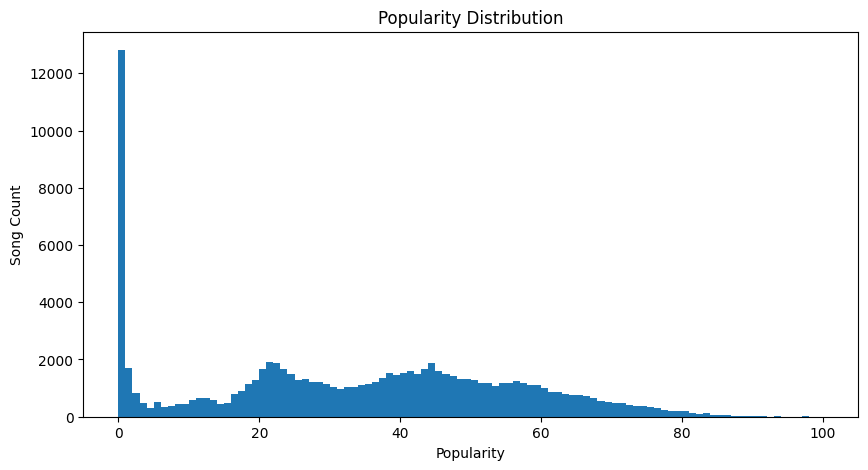

In [ ]:
fig, ax = plt.subplots(figsize=(10,5)) #setting the figure size
plt.hist(y_train, bins=100) #computing the histogram of popularities
ax.grid(False)
ax.set(title='Popularity Distribution', xlabel='Popularity', ylabel='Song Count')

In [ ]:
#converting train labels to binary values using 40 as the threshold
for i in range(len(y_train)):
  if y_train[i]>39:
    y_train[i]=1
  else:
    y_train[i]=0

In [ ]:
#converting test labels to binary values using 40 as the threshold
for i in range(len(y_test)):
  if y_test[i]>39:
    y_test[i]=1
  else:
    y_test[i]=0

In [ ]:
input_shape = X_train.shape[1:] #input shape

#setting a random seed to make the results reproducible
np.random.seed(42)
tf.random.set_seed(42)

nn_model = keras.Sequential(name='nn_model') #creating the sequential neural network

nn_model.add(layers.Flatten(input_shape=input_shape)) #adding input layer to flatten the input into 1D

nn_model.add(layers.BatchNormalization()) #adding batch normalization layer

#adding five hidden dense layers with relu activation function and batch normalization layers
nn_model.add(layers.Dense(256, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(128, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(64, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.BatchNormalization())

nn_model.add(layers.Dense(1, activation='sigmoid')) #adding the output layer with sigmoid activation function

opt = keras.optimizers.Adam(learning_rate=0.01)

#adding binary crossentropy as the loss function, adam as the optimizer, and accuracy, mse, mae, and mape as the evaluation metric
nn_model.compile(loss='binary_crossentropy',
            optimizer=opt,
            metrics=['accuracy', 'Precision', 'Recall'])

nn_model.summary() #printing model's architecture

nn_model_history = nn_model.fit(X_train_std, y_train, epochs=500, batch_size=64, verbose=1, validation_data=(X_test_std, y_test))

Model: "nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 13)                0         
                                                                 
 batch_normalization (Batch  (None, 13)                52        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               3584      
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512

## Support Vector Machines



In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
url = '/content/drive/MyDrive/dataset.csv'

dataset = pd.read_csv(url)
columns_to_preserve = ['artists', 'tempo', 'instrumentalness', 'popularity', 'speechiness', 'valence', 'danceability', 'album_name', 'acousticness', 'track_genre']
column_data_types = {'Unnamed': 'int', 'track_id': 'str', 'artists': 'str', 'album_name':'str', 'track_name':'str', 'popularity':'int', 'duration_ms': 'int', 'explicit': 'bool', 'danceability': 'float', 'energy':'float', 'key':'float', 'loudness':'float', 'mode':'int', 'speechiness':'float', 'acousticness':'float', 'instrumentalness':'float', 'liveness':'float', 'valence':'float', 'tempo':'float', 'time_signature': 'int', 'track_genre': 'str'}
synthetic_data = pd.read_csv(url, dtype=column_data_types)

features = synthetic_data[['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo']].values
target = synthetic_data['track_genre'].values

unique_labels = np.unique(target)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
encoded_target = np.array([label_mapping[label] for label in target])
encoded_target = np.where(encoded_target == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(features, encoded_target, test_size=0.2, random_state=42)

class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def initialize_weights(self, n_features):
        return np.zeros(n_features)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = self.initialize_weights(n_features)
        self.bias = 0

        for iteration in range(1, self.n_iterations + 1):
            margins = y * (X.dot(self.weights) - self.bias)
            hinge_loss = np.maximum(0, 1 - margins)

            grad_weights = -X.T.dot(y * (margins <= 1))
            grad_bias = -np.sum(y * (margins <= 1))

            self.weights -= self.lr * (grad_weights + 2 * self.lambda_param * self.weights)
            self.bias -= self.lr * grad_bias


    def predict(self, X):
        return np.sign(X.dot(self.weights) - self.bias)

svm_model = SVM(learning_rate=0.01, lambda_param=0.01, n_iterations=1000)
svm_model.fit(X_train, y_train)

model = SVC()
accuracy_scores = cross_val_score(model, features, encoded_target, cv=5)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation: {std_accuracy}")
# Use the SVM model for predictions on the test set
y_pred = svm_model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)

mse = np.round(np.mean((y_test - y_pred) ** 2), 5)
mae = np.round(np.mean(np.abs(y_test - y_pred)), 5)
mape = np.round(np.mean(np.abs((y_test - y_pred) / (y_test + 1e-6))) * 100, 5)

start = datetime.now()
metric_output = {
    'mean_squared_error': mse,
    'mean_absolute_error': mae,
    'mean_absolute_percentage_error': mape,
    'time': (datetime.now() - start).seconds
}

print(metric_output)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Accuracy: 0.9912280701754386
Standard Deviation: 0.0
Test Accuracy: 0.9906578947368421
{'mean_squared_error': 0.03737, 'mean_absolute_error': 0.01868, 'mean_absolute_percentage_error': 1.86842, 'time': 0}


## Custom Implementation

## Liner Regression(Scratch)

In [ ]:
import numpy as np
class Multiple_Linear_Regression():
    def __init__ (self):
        self.theta=np.zeros(int(np.random.random()),float)[:,np.newaxis];

    def fit(self, X_train, y_train):
        X_b = np.c_[np.ones(len(X_train)), X_train]
        theta_bst = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
        self.theta = theta_bst

    def predict(self, X_test):
        X_test = np.c_[np.ones((len(X_test), 1)), X_test]
        y_predict = np.dot(X_test, self.theta)

        return y_predict

In [ ]:
scratch_model = Multiple_Linear_Regression()
scratch_model.fit(X_train, y_train)
scratch_y_preds = scratch_model.predict(X_test)

In [ ]:
lm = LinearRegression() #sci-kit learn
lm.fit(X_train, y_train)
y_preds = lm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
def model_metrics(y_test, y_pred, decimals = 5):
    start = datetime.now()
    mse = np.round(mean_squared_error(y_test, y_pred),decimals)
    mae = np.round(mean_absolute_error(y_test, y_pred),decimals)
    mape = np.round(mean_absolute_percentage_error(y_test, y_pred),decimals)
    r2 = np.round(r2_score(y_test, y_pred),decimals)
    metric_output = {
        'mean_squared_error': mse
        , 'mean_absolute_error': mae
        , 'mean_absolute_percentage_error': mape
        , 'R2_score': r2
        , 'time': (datetime.now() - start).seconds
    }
    return metric_output

print(model_metrics(y_test, scratch_y_preds))
print(model_metrics(y_test, y_preds))

t_value, p_value=stats.ttest_ind(y_test, scratch_y_preds, equal_var=False)
print(t_value)
print(p_value)
t_value, p_value=stats.ttest_ind(y_test, y_preds, equal_var=False)
print(t_value)
print(p_value)

{'mean_squared_error': 435.00852, 'mean_absolute_error': 17.16321, 'mean_absolute_percentage_error': 1.459399703236128e+16, 'R2_score': 0.04532, 'time': 0}
{'mean_squared_error': 435.0085, 'mean_absolute_error': 17.16321, 'mean_absolute_percentage_error': 1.4593938e+16, 'R2_score': 0.04532, 'time': 0}
0.6964908964995179
0.486128439307817
0.6974422344295028
0.4855330722869363


### XGBoost(Scratch)

In [ ]:
import math
import numpy as np
import pandas as pd
from collections import defaultdict

class XGBoostModel():
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] \
            if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] \
            if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] \
            if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] \
            if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)

    def fit(self, X, y, objective, num_boost_round, verbose=False):
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        self.boosters = []
        for i in range(num_boost_round):
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y),
                                     size=math.floor(self.subsample*len(y)),
                                     replace=False)
            booster = TreeBooster(X, gradients, hessians,
                                  self.params, self.max_depth, sample_idxs)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            if verbose:
                print(f'[{i}] train loss = {objective.loss(y, current_predictions)}')

    def predict(self, X):
        return (self.base_prediction + self.learning_rate
                * np.sum([booster.predict(X) for booster in self.boosters], axis=0))

class TreeBooster():

    def __init__(self, X, g, h, params, max_depth, idxs=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] \
            if params['min_child_weight'] else 1.0
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] \
            if params['colsample_bynode'] else 1.0
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda) # Eq (5)
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = TreeBooster(self.X, self.g, self.h, self.params,
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params,
                                 self.max_depth - 1, self.idxs[right_idx])

    @property
    def is_leaf(self): return self.best_score_so_far == 0.

    def _find_better_split(self, feature_idx):
        x = self.X.values[self.idxs, feature_idx]
        g, h = self.g[self.idxs], self.h[self.idxs]
        sort_idx = np.argsort(x)
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        for i in range(0, self.n - 1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
            sum_g_left += g_i; sum_g_right -= g_i
            sum_h_left += h_i; sum_h_right -= h_i
            if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
            if sum_h_right < self.min_child_weight: break

            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                            + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                            - (sum_g**2 / (sum_h + self.reg_lambda))
                            ) - self.gamma/2
            if gain > self.best_score_so_far:
                self.split_feature_idx = feature_idx
                self.best_score_so_far = gain
                self.threshold = (x_i + x_i_next) / 2

    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])

    def _predict_row(self, row):
        if self.is_leaf:
            return self.value
        child = self.left if row[self.split_feature_idx] <= self.threshold \
            else self.right
        return child._predict_row(row)

class SquaredErrorObjective():
    def loss(self, y, pred): return np.mean((y - pred)**2)
    def gradient(self, y, pred): return pred - y
    def hessian(self, y, pred): return np.ones(len(y))

In [ ]:
# Scratch takes a while...iteration=100 -> 20mins
# Scratch takes a while...iteration=500 -> 2hrs

params = { # optimal parameters from CV
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'gamma': 0.5,
    # 'n_estimator': 500,
}
num_boost_round = 500

# train the from-scratch XGBoost model
model_scratch = XGBoostModel(params, random_seed=42)
model_scratch.fit(pd.DataFrame(X_train), y_train, SquaredErrorObjective(), num_boost_round)
# model_scratch.fit(pd.DataFrame(X_train), y_train, SquaredErrorObjective())

In [ ]:
# Performance from scratch XGBoost
pred_xgb = model_scratch.predict(pd.DataFrame(X_test))
mse = np.round(mean_squared_error(y_test, pred_xgb),5)
mae = np.round(mean_absolute_error(y_test, pred_xgb),5)
mape = np.round(mean_absolute_percentage_error(y_test, pred_xgb),5)
r2 = np.round(r2_score(y_test, pred_xgb),5)
metric_output = {
    'mean_squared_error': mse
    , 'mean_absolute_error': mae
    , 'mean_absolute_percentage_error': mape
    , 'R2_score': r2
}
print(metric_output)

In [ ]:
# Performance from package XGBoost
from xgboost import XGBRegressor
XGBreg = XGBRegressor(learning_rate=0.1,
                      n_estimators=500,
                      subsample = 0.8,
                      max_depth=5,
                      gamma=0
)

XGBreg.fit(X_train, y_train)
y_pred = XGBreg.predict(X_test)
mse = np.round(mean_squared_error(y_test, y_pred),5)
mae = np.round(mean_absolute_error(y_test, y_pred),5)
mape = np.round(mean_absolute_percentage_error(y_test, y_pred),5)
metric_output = {
    'mean_squared_error': mse
    , 'mean_absolute_error': mae
    , 'mean_absolute_percentage_error': mape
}
print(metric_output)

### Polynomial Regression

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array


from itertools import chain, combinations_with_replacement as cbr

In [ ]:
class Polynomial_Features:

  def __init__(self, degrees = 2):
    '''
      In this basic version, we will take combinations of all interactions
      And bias will be included. No option to change

    '''

    self.degrees = degrees

    self.n_features = 0
    self.n_samples = 0

    self.n_features_out = 0

  def get_combinations(self):

    '''
    sklearn considers interactions between features, i.e, x0 * x1 is also taken into consideration along with x0, x1^2, etc..

    '''

    iter = chain.from_iterable(
            cbr(range(self.n_features), i) for i in range(1, self.degrees + 1)
        )

    comb = [i for i in iter]

    #print('No. of combination: ', len(comb))

    self.n_features_out = len(comb)

    return comb

  def fit_transform(self, X):

    self.n_samples, self.n_features = X.shape
    #print("Data shape is: ", X.shape)
    combs = self.get_combinations()

    X_ = np.zeros((self.n_samples, self.n_features_out))

    for i, comb in enumerate(combs):
      X_[:, i] = X[:, comb].prod(1)

    return X_


We'll define both Logistic Regression and Linear Regression to be an sklearn Estimator. They'll inherit from **BaseEstimator** and *mixin* classes. This will make it easier to use sklearn libraries related to metrics

In [ ]:
class Linear_Regression(BaseEstimator, RegressorMixin):

  def __init__(self, a=0.01, iter=100):
    self.a = a
    self.iter = iter

  def fit(self, X, Y):
    self.n_samples, self.n_features = X.shape
    self.W = np.random.rand(self.n_features)
    self.b = 0

    for i in range(self.iter):
      Y_hat = np.dot(X, self.W) + self.b

      w_grad = np.dot(X.T, Y_hat - Y) / self.n_samples
      b_grad = np.sum(Y_hat - Y) / self.n_samples

      self.W = self.W - self.a * w_grad
      self.b = self.b - self.a * b_grad

    return self

  def predict(self, X):
    return np.dot(X, self.W) + self.b

In [ ]:
class Polynomial_Regression(BaseEstimator, RegressorMixin):

  def __init__(self, a=0.01, iter=1000, degrees=2):
    self.a = a
    self.degrees = degrees
    self.iter = iter

  def get_X(self, X):

    poly = Polynomial_Features(degrees = self.degrees)
    X = poly.fit_transform(X_train)

    X = StandardScaler().fit_transform(X_train)

    return X

  def fit(self, X, Y):

    self.X = self.get_X(X)
    self.Y = Y

    self.n_samples, self.n_features = self.X.shape
    self.W = np.random.rand(self.n_features)
    self.b = 0

    for i in range(self.iter):
      Y_hat = np.dot(self.X, self.W) + self.b

      w_grad = np.dot(self.X.T, Y_hat - Y) / self.n_samples
      b_grad = np.sum(Y_hat - self.Y) / self.n_samples

      self.W = self.W - self.a * w_grad
      self.b = self.b - self.a * b_grad

    return self

  def predict(self, X):
    X = self.get_X(X)
    return np.dot(X, self.W) + self.b

In [ ]:
def polynomial_regression(degree=2):

  X_train, X_test, Y_train, Y_test = get_data(df)
  print(X_train.shape)

  poly = Polynomial_Features(degrees = 2)

  X_train = poly.fit_transform(X_train)
  X_test = poly.fit_transform(X_test)

  #Standardize X
  X_train = StandardScaler().fit_transform(X_train)
  X_test = StandardScaler().fit_transform(X_test)

  polynomial_model = Linear_Regression(a=0.01, iter=500)
  polynomial_model.fit(X_train, Y_train)

  Y_pred = polynomial_model.predict(X_test)
  print(Y_pred)

  metrix = model_metrics(polynomial_model, X_test, Y_test, X_train = X_train, y_train = Y_train, fit=False, y_pred=Y_pred)

  return polynomial_model, metrix

In [ ]:
_, metrix = polynomial_regression(degree=2)
print(metrix)

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
(85525, 15)
[37.83751031 36.16912162 33.74170259 ... 35.57684664 36.13220909
 41.43131709]
{'MSE': 423.71485, 'MAE': 16.72223, 'MAPE': 1.4613256937947966e+16, 'R2_score': 0.06708, 'Time': 0}


In [ ]:
#A simple Logistic Regression Implementation

class Logistic_Regression(BaseEstimator, ClassifierMixin):

  def __init__(self, a=0.01, iter=100):

    self.iter = iter
    self.a = a

  def sigmoid(self, y_hat):

    z = 1/(1 + np.exp(-y_hat))
    preds = np.where(z > 0.5, 1, 0)

    return preds

  def fit(self, X, Y):

    X, Y = check_X_y(X, Y)

    self.X_ = X
    self.y_ = Y

    self.n_samples, self.n_features = X.shape

    self.W = np.random.rand(self.n_features)
    self.b = 0

    for i in range(self.iter):

      y_hat = np.dot(X, self.W) + self.b
      y_hat = self.sigmoid(y_hat) #Use activation function to convert y_hat to sigmoid

      w_grad = - (2 * np.dot(X.T, (self.Y - y_hat))) / self.n_samples
      b_grad = - (2 * np.sum(self.Y - y_hat)) / self.n_samples

      self.W = self.W - self.a * w_grad
      self.b = self.b - self.a * b_grad

    return self

  def predict(self, X):

    check_is_fitted(self)

    y_hat_ = np.dot(X, self.W) + self.b
    return self.sigmoid(y_hat_)


In [ ]:
#Full custom implementation of Polynomial Logistic Regression as an sklearn estimator

class Polynomial_Logistic_Regression(BaseEstimator, ClassifierMixin):

  def __init__(self, degrees=2, a=0.01, iter=1000):

    self.iter = iter
    self.a = a

    self.degrees = degrees

  def sigmoid(self, y_hat):

    z = 1/(1 + np.exp(-y_hat))
    preds = np.where(z > 0.5, 1, 0)

    return preds

  def get_X(self, X):

    poly = Polynomial_Features(degrees=self.degrees)
    X_ = poly.fit_transform(X)
    X_ = StandardScaler().fit_transform(X_)

    return X_

  def fit(self, X, Y):

    X, Y = check_X_y(X, Y)

    self.classes_ = np.unique(Y)

    check_classification_targets(Y)

    self.X_ = self.get_X(X)
    self.y_ = Y

    self.n_samples, self.n_features = self.X_.shape

    self.W = np.random.rand(self.n_features)
    self.b = 0

    for i in range(self.iter):

      y_hat_ = np.dot(self.X_, self.W) + self.b
      y_hat_ = self.sigmoid(y_hat_) #Use activation function to convert y_hat to sigmoid

      w_grad = - (2 * np.dot(self.X_.T, (self.y_ - y_hat_))) / self.n_samples
      b_grad = - (2 * np.sum(self.y_ - y_hat_)) / self.n_samples

      self.W = self.W - self.a * w_grad
      self.b = self.b - self.a * b_grad

    return self

  def predict(self, X):

    X_ = self.get_X(X)

    check_is_fitted(self, ['X_', 'y_', 'classes_'])

    X_ = check_array(X_)

    y_hat_ = np.dot(X_, self.W) + self.b
    return self.sigmoid(y_hat_)


from sklearn.utils.estimator_checks import check_estimator
#print(check_estimator(Polynomial_Logistic_Regression()))


In [ ]:
def polynomial_logistic_regression(df, degree=2, cutoff=50):

  X_train, X_test, Y_train, Y_test = get_data_bin_classfication(df, cutoff, resample_=True)

  poly_logistic_regression = Polynomial_Logistic_Regression(degrees=degree, iter=500)

  print("Fitting model with degree {} ...".format(degree))

  model = poly_logistic_regression.fit(X_train, Y_train)

  Y_pred_train = model.predict(X_train)
  Y_pred_test = model.predict(X_test)

  train_accuracy = metrics.accuracy_score(Y_pred_train, Y_train)
  test_accuracy = metrics.accuracy_score(Y_pred_test, Y_test)

  train_preciscion = metrics.precision_score(Y_train, Y_pred_train)
  test_preciscion = metrics.precision_score(Y_test, Y_pred_test)

  f1_train = metrics.f1_score(Y_train, Y_pred_train)
  f1_test = metrics.f1_score(Y_test, Y_pred_test)

  recall_train = metrics.recall_score(Y_train, Y_pred_train)
  recall_test = metrics.recall_score(Y_test, Y_pred_test)

  scores = {'Train Accuracy': np.round(train_accuracy, 3), 'Test Accuracy': np.round(test_accuracy, 3),
            'Train Precision': np.round(train_preciscion, 3), 'Test Precision': np.round(test_preciscion, 3),
            'F1 Train': np.round(f1_train, 3), 'F1 Test': np.round(f1_test, 3),
            'Recall Train': np.round(recall_train, 3), 'Recall Test': np.round(recall_test, 3)}

  print("Finished predicting...")

  plt.figure(figsize=(10,6))
  ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
  plt.show()



  return model, scores

Using default split of 80-20
Using Train 0.8 - 0.2 Test split
Fitting model with degree 2 ...
Finished predicting...


<Figure size 1000x600 with 0 Axes>

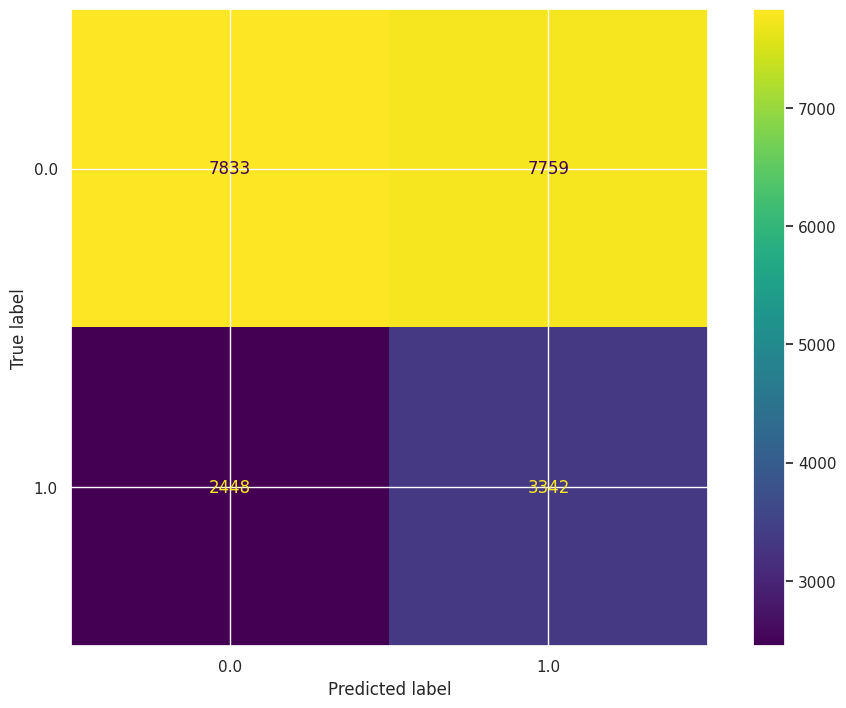

In [ ]:
_, scores = polynomial_logistic_regression(df, 2, cutoff=50)

In [ ]:
print(scores)

{'Train Accuracy': 0.535, 'Test Accuracy': 0.523, 'Train Precision': 0.534, 'Test Precision': 0.301, 'F1 Train': 0.539, 'F1 Test': 0.396, 'Recall Train': 0.544, 'Recall Test': 0.577}


Cross Validation to find the polynomial model with the best scores

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report

In [ ]:
#Define the models to be cross validated using GridSearch
#For this validation, we shall take degrees of 2, 3 and 4
#Cutoff scores of 50 shall be chosen (75th percentile)

def grid_search_CV_custom():

  X_train, X_test, Y_train, Y_test = get_data_bin_classfication(df, 50, train_size=0.25, resample_=True)

  params = {'degrees': [2, 3]}
  grid = GridSearchCV(Polynomial_Logistic_Regression(iter=500), params, refit=True,
                      scoring=make_scorer(f1_score, average='weighted'), verbose=True)

  grid.fit(X_train, Y_train)

  print('Selected degree hyperparameter: ', grid.best_params_)
  y_pred = grid.predict(X_test)

  return classification_report(Y_test, y_pred, output_dict=True)


In [ ]:
report = grid_search_CV_custom()

Using Train 0.75 - 0.25 Test split
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Selected degree hyperparameter:  {'degrees': 3}


In [ ]:
print(report)

{'0.0': {'precision': 0.7717881000466056, 'recall': 0.5127464134585612, 'f1-score': 0.6161478357931292, 'support': 19378}, '1.0': {'precision': 0.3184147838013427, 'recall': 0.6002177166961491, 'f1-score': 0.41609282143194043, 'support': 7349}, 'accuracy': 0.5367979945373592, 'macro avg': {'precision': 0.5451014419239741, 'recall': 0.5564820650773552, 'f1-score': 0.5161203286125348, 'support': 26727}, 'weighted avg': {'precision': 0.6471261289654353, 'recall': 0.5367979945373591, 'f1-score': 0.5611396305871436, 'support': 26727}}


### Comparison with sklearn library

The GridSearch Cross Validation below is performed using the standard sklearn implementation of PolynomialFeatures and Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def grid_search_CV():

  #Need to build a pipeline for standard sklearn Polynomial Regression

  X_train, X_test, Y_train, Y_test = get_data_bin_classfication(df, 50, train_size=0.25, resample_=True)
  params = [{'polynomial__degree': [2, 3]}]

  pipeline = Pipeline(steps=[('polynomial', PolynomialFeatures()), ('logistic', LogisticRegression(solver='liblinear', max_iter=500))])

  grid = GridSearchCV(pipeline, params, refit=True, scoring=make_scorer(f1_score, average='weighted'), verbose=True)
  grid.fit(X_train, Y_train)

  print(grid.best_params_)
  y_pred = grid.predict(X_test)

  return classification_report(Y_test, y_pred, output_dict=True)

In [ ]:
report = grid_search_CV()

Using Train 0.75 - 0.25 Test split
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'polynomial__degree': 2}


In [ ]:
print(report)

{'0.0': {'precision': 0.7276967930029155, 'recall': 0.5789690721649484, 'f1-score': 0.6448686665709774, 'support': 19400}, '1.0': {'precision': 0.27665603967410557, 'recall': 0.42636822710522726, 'f1-score': 0.33557119071915786, 'support': 7327}, 'accuracy': 0.5371347326673401, 'macro avg': {'precision': 0.5021764163385105, 'recall': 0.5026686496350878, 'f1-score': 0.49021992864506764, 'support': 26727}, 'weighted avg': {'precision': 0.6040474646218705, 'recall': 0.5371347326673401, 'f1-score': 0.5600771596466582, 'support': 26727}}
